In [1]:
#imports and calibration
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pickle
import scipy.optimize as opt
import scipy.stats as sts
import math
import vifida as vif

os.chdir("C:\\Users\\GUR\\Code\\PoDA-M1\\Calibration")
cFile = open('M1.cal', 'rb')
[ieq,seq,signal2cresc,signal2decre,cresc2signal,decre2signal,model,sourcePositionVideo,sourceSpeedVideo] = pickle.load(cFile)
cFile.close()

projectName="SOL_20250612_jueves"
os.chdir("C:\\Users\\GUR\\Code\\PoDA-M1\\Projects\\"+projectName)



In [2]:
maxSpeed=9

C:\Users\GUR\Code\ViFiDA\src\vifida.py:488: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(amplitude/ref)


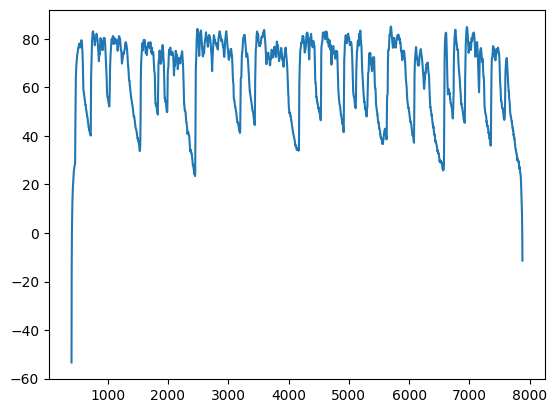

In [3]:
#Create a set of instructions from audio with the naive approach
slowFactor = 4
framerate = 25

wavfilepath = projectName+".WAV"
#framerate*slowfactor accounts for the fact of recording at a lower speed
#it is only used here, from this point we work at the actual recording speed
sensed, samplerate, duration = vif.wavToSensed(wavfilepath,framerate*slowFactor,forceMono=True)

plt.plot(sensed)


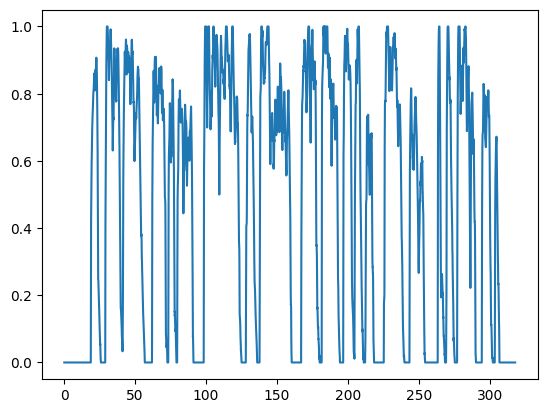

In [4]:
#adjust the variables to get nice dinamycs
drive = vif.sensedToFuzzy(sensed,thres=35,k=1.15)
time = np.linspace(0,len(drive)-1,len(drive),dtype="float64")/framerate

plt.plot(time,drive)

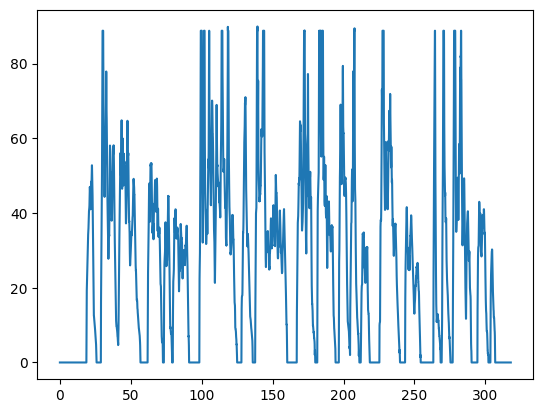

In [5]:
#visualise it angularly
ideal = signal2cresc(drive)*90

plt.plot(time,ideal)

Number of speeds unreachable:
566
Fraction unreachable:
0.0712


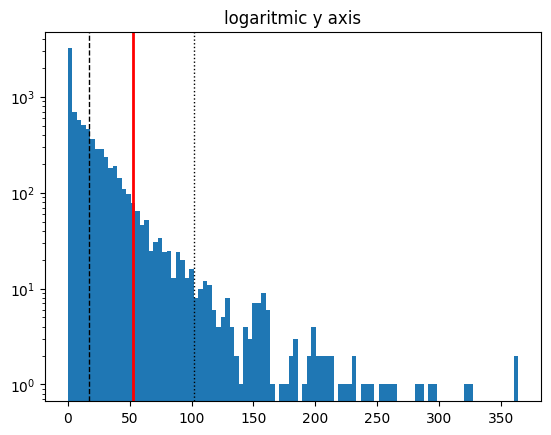

In [6]:
#study speed distributions
idealSpeeds=np.zeros( (len(ideal)-1,1) )

for i in range(len(idealSpeeds)):
    idealSpeeds[i]=(ideal[i+1]-ideal[i])*framerate

absIS=abs(idealSpeeds)

#compare to reachable speeds
absInputs=np.linspace(1,maxSpeed,maxSpeed)
absSpeeds=absInputs*ieq

plt.hist(absIS,bins = 100)
plt.axvline(absIS.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(absSpeeds.max(), color='red', linestyle='-', linewidth=2)
plt.axvline(absIS.mean()+3*absIS.std(), color='k', linestyle='dotted', linewidth=1)
plt.yscale('log')
plt.title("logaritmic y axis")

print("Number of speeds unreachable:")
print(sum(absIS>absSpeeds.max())[0])
print("Fraction unreachable:")
print(round((sum(absIS>absSpeeds.max())/len(absIS))[0],4))


In [7]:
def createOrders(ideal,time,ind,maxSpeed=9):
    #setup
    N=len(ind)-1
    orders=np.zeros((N+1,2))
    controlIdeal=ideal[ind]
    controlTime=time[ind]
    #loop orders
    for i in range(N):
        thisTime = controlTime[i+1]-controlTime[i]
        #write speed
        orders[i,0]=(controlIdeal[i+1]-controlIdeal[i])/thisTime
        orders[i,0]=round(orders[i,0]/ieq)
        if orders[i,0] > maxSpeed:
            orders[i,0] = maxSpeed
        elif orders[i,0] < -maxSpeed:
            orders[i,0] = -maxSpeed
        #write steps
        if orders[i,0] == 0:
            orders[i,1]=round(thisTime*1000)
            #update control point
            controlIdeal[i+1]=controlIdeal[i]
        else :
            orders[i,1]=abs(orders[i,0]*ieq)*thisTime
            orders[i,1]=round(orders[i,1]/seq)
            #update control point
            controlIdeal[i+1]=controlIdeal[i]+math.copysign(orders[i,1],orders[i,0])*seq

    """ plt.plot(time,ideal)
    plt.plot(time[ind],ideal[ind],linestyle='',marker='x')
    plt.show() """
    return orders

def appyOrders(orders,framerate=25):
    rebuilt=np.zeros_like((1,))
    thisInd=0
    for i in range(orders.shape[0]):
        thisI=orders[i,0]
        thisS=orders[i,1]
        if thisI==0:
            if thisS==0:
                break
            else: #if v==0, s are waiting time in ms
                nextInd= round(thisInd+thisS/1000*framerate)
                interval=np.ones((nextInd-thisInd+1,1))*rebuilt[thisInd]
        else:
            thisTime= thisS*seq / (abs(thisI)*ieq)
            nextInd= thisInd + thisTime*framerate
            nextInd= round(nextInd)
            interval=np.linspace(rebuilt[thisInd],
            rebuilt[thisInd]+math.copysign(thisS,thisI)*seq,
            nextInd-thisInd+1)
        rebuilt=np.append(rebuilt,interval.flatten()[1:])
        """ print('************* '+str(i))
        print('thisInd: ', thisInd)
        print('nextInd: ', nextInd)
        print('interval length: ', nextInd-thisInd)
        print('interval:')
        print(interval.flatten())
        print(len(interval))
        print('rebuilt:')
        print(rebuilt)
        print(len(rebuilt))
        if i==5:
            break """
        thisInd=nextInd
    return rebuilt

def mergeControlPoints(orders,oldInd):
    ind=oldInd.copy()
    N=len(orders)-1
    extra=0
    for i in range(N):
        if (orders[i+1,:]==np.array([0,0])).all():
            break

        thisO=orders[i,:]
        while orders[i+1,0]==thisO[0]:
            if orders[i+1,1]==0:
                break
            orders[i,1]=orders[i,1]+orders[i+1,1]   #merge
            orders[i+1:-1,:]=orders[i+2:,:]         #send to back as (0,0)
            ind[i+1:-1]=ind[i+2:]
            extra=extra+1
    ind=ind[:N-extra]
    return ind,extra

def updateControlPoints(ideal,rebuilt,oldInd,extra):
    N=len(oldInd)+extra
    ind=oldInd.copy()
    ind=np.append(ind,len(ideal)-1)
    err=abs(ideal-rebuilt[:len(ideal)])
    candidates=np.empty(0)
    candInd=np.empty(0,dtype=int)
    for i in range(N-extra): #maximum error point in each interval as candidate
        thisC=max(err[ ind[i]:ind[i+1] ])
        thisI=ind[i]+np.where(err[ ind[i]:ind[i+1] ]==thisC)[0][0]
        candidates=np.append(candidates,thisC)
        candInd=np.append(candInd,thisI)
    #avoid index repetition
    common=np.intersect1d(candInd,ind)
    discard=np.in1d(candInd,common)
    candidates=candidates[discard==False]
    candInd=candInd[discard==False]
    newInd=candInd[np.argsort(-candidates)][:extra]
    ind=np.sort(np.append(ind,newInd))
    return ind



Typical angular error:
2.6
Max angular error:
34.3


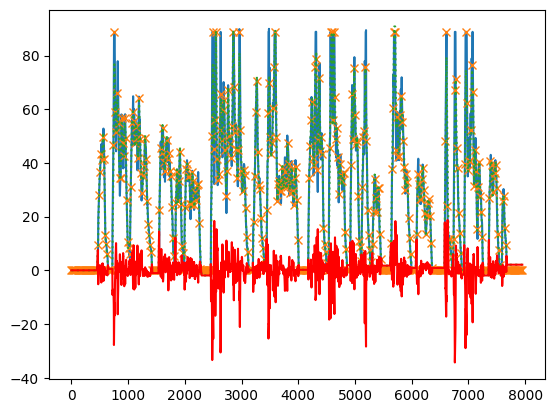

In [8]:
#test functions
N=440
ind=np.linspace(0,len(ideal)-1,N+1,dtype='int')

orders1=createOrders(ideal,time,ind,maxSpeed)
rebuilt1=appyOrders(orders1)

plt.plot(ideal)
plt.plot(ind,ideal[ind],linestyle='',marker='x')
plt.plot(rebuilt1,linestyle=':')
plt.plot(rebuilt1-ideal,color='red')
err=np.abs(rebuilt1[:len(ideal)]-ideal)
print("Typical angular error:")
print(round(np.mean(err),1))
print("Max angular error:")
print(round(np.max(err),1))

In [9]:
def optimalOrders(ideal,time,N,verbose=1):
    aux=0
    meanE=np.empty(0)
    maxE=np.empty(0)
    extras=np.empty(0)
    #Initialise equidistant control points
    ind=np.linspace(0,len(ideal)-1,N+1,dtype='int')
    #Create orders:
    orders=createOrders(ideal,time,ind,maxSpeed)
    rebuilt=appyOrders(orders)
    if verbose>1:
        err=np.abs(rebuilt[:len(ideal)]-ideal)
        meanE=np.append(meanE, round(np.mean(err),1) )
        maxE=np.append(maxE, round(np.max(err),1) )
    #Check for orders to merge:
    newInd,extra=mergeControlPoints(orders,ind)
    extras=np.append(extras,extra)
    while extra>0:
        if aux>30:
            if extras[aux-1]==extras[aux]:
                break
        """ print(extra)
        print("in: ", aux) """
        ind=updateControlPoints(ideal,rebuilt,newInd,extra)
        orders=createOrders(ideal,time,ind,maxSpeed)
        rebuilt=appyOrders(orders)
        newInd,extra=mergeControlPoints(orders,ind)
        extras=np.append(extras,extra)
        aux=aux+1
        if verbose>1:
            err=np.abs(rebuilt[:len(ideal)]-ideal)
            meanE=np.append(meanE, round(np.mean(err),1) )
            maxE=np.append(maxE, round(np.max(err),1) )
    if verbose>1:
        print("Number of iterations: ", aux+1)
        plt.plot(meanE)
        plt.title("typical error")
        plt.show()
        plt.plot(maxE)
        plt.title("max error")
        plt.show()
    return orders,rebuilt,ind

C:\Users\GUR\AppData\Local\Temp\ipykernel_12224\3198371944.py:101: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  discard=np.in1d(candInd,common)


Number of iterations:  32


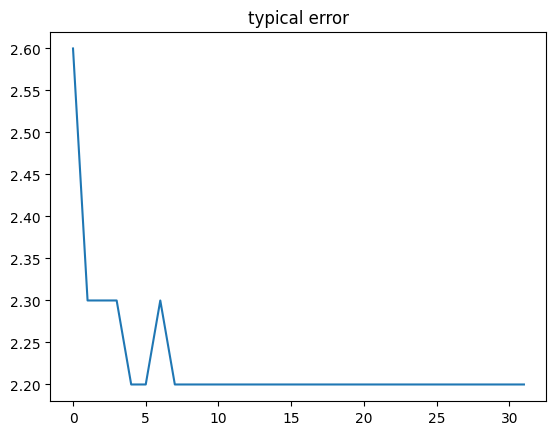

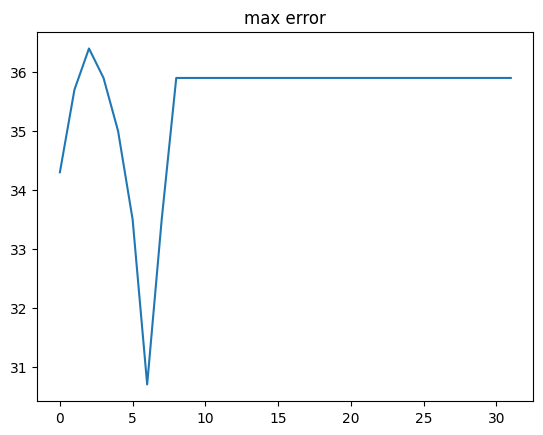

In [10]:
#test last function
orders,rebuilt,ind = optimalOrders(ideal,time,N,verbose=2)

Typical angular error:
2.2
Max angular error:
35.9


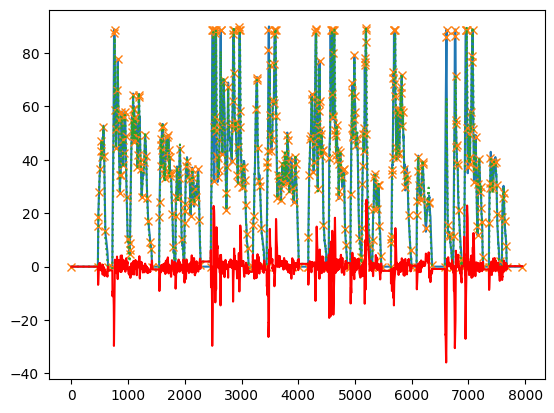

In [11]:
plt.plot(ideal)
plt.plot(ind,ideal[ind],linestyle='',marker='x')
plt.plot(rebuilt,linestyle=':')
plt.plot(rebuilt-ideal,color='red')
err=np.abs(rebuilt[:len(ideal)]-ideal)
print("Typical angular error:")
print(round(np.mean(err),1))
print("Max angular error:")
print(round(np.max(err),1))

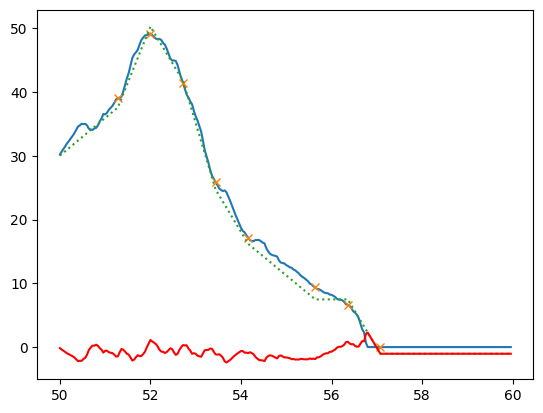

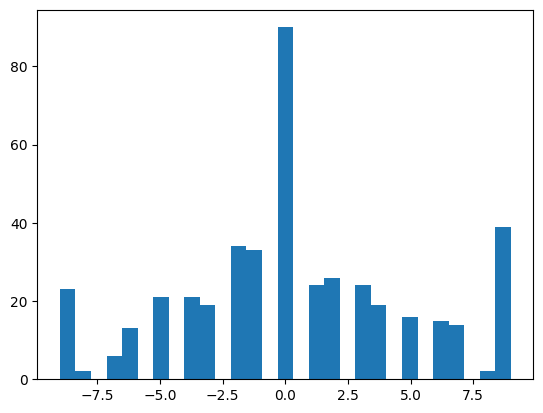

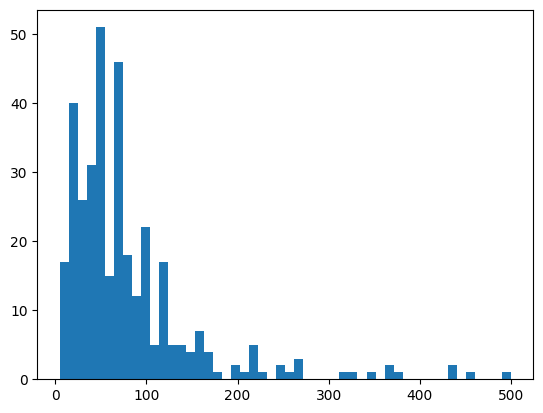

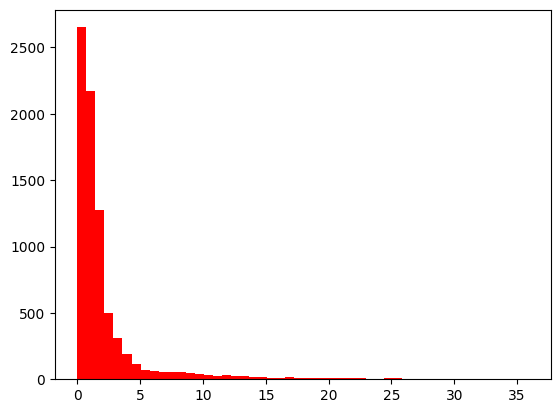

In [12]:
#zoom a particular region (based on index)
aux1=1250
aux2=1500
plt.plot(time[aux1:aux2],ideal[aux1:aux2])
plt.plot(time[ind[ (ind>aux1)&(ind<aux2) ]],ideal[ind[ (ind>aux1)&(ind<aux2) ]],linestyle='',marker='x')
plt.plot(time[aux1:aux2],rebuilt[aux1:aux2],linestyle=':')
plt.plot(time[aux1:aux2],rebuilt[aux1:aux2]-ideal[aux1:aux2],color='red')
plt.show()

#velocity distribution
plt.hist(orders[:,0],bins=29)
plt.show()

#step number distribution
plt.hist(orders[orders[:,0]!=0,1],bins=50)
plt.show()

#error distribution
plt.hist(abs(rebuilt-ideal),bins=50,color='red')
plt.show()


" \n#zoom a particular region (based on index)\naux1=1250\naux2=1500\nplt.plot(time[aux1:aux2],ideal[aux1:aux2])\nplt.plot(time[ind[ (ind>aux1)&(ind<aux2) ]],ideal[ind[ (ind>aux1)&(ind<aux2) ]],linestyle='',marker='x')\nplt.plot(time[aux1:aux2],rebuilt[aux1:aux2],linestyle=':')\nplt.plot(time[aux1:aux2],rebuilt[aux1:aux2]-ideal[aux1:aux2],color='red')\nplt.show() "

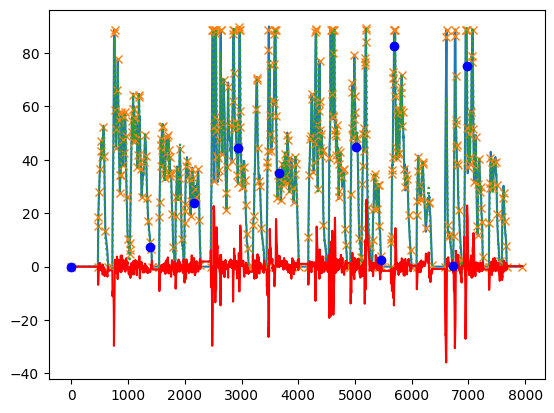

In [13]:
auxInd=np.argsort(-orders[:,1])
select = 10

plt.plot(ideal)
plt.plot(ind,ideal[ind],linestyle='',marker='x')
plt.plot(rebuilt,linestyle=':')
plt.plot(rebuilt-ideal,color='red')
err=np.abs(rebuilt[:len(ideal)]-ideal)
plt.plot(ind[auxInd[0:select]],rebuilt[ind[auxInd[0:select]]],linestyle='',marker='o',color='blue')

""" 
#zoom a particular region (based on index)
aux1=1250
aux2=1500
plt.plot(time[aux1:aux2],ideal[aux1:aux2])
plt.plot(time[ind[ (ind>aux1)&(ind<aux2) ]],ideal[ind[ (ind>aux1)&(ind<aux2) ]],linestyle='',marker='x')
plt.plot(time[aux1:aux2],rebuilt[aux1:aux2],linestyle=':')
plt.plot(time[aux1:aux2],rebuilt[aux1:aux2]-ideal[aux1:aux2],color='red')
plt.show() """

In [14]:
orders[auxInd,1]
print(len(ind)==len(orders))
print(ind[0])

True
0


In [15]:
#Create instructions
""" small_stepper.setSpeed(1.0000);
small_stepper.step(0);
delay(2000); """

#make sure the file is empty
f = open('instructions.txt', 'w')
f.close()

#write instructions
f = open('instructions.txt', 'a')
f.write("//"+str(projectName)+"\n")
f.write("\t\t\t\t\t")
for i in range(len(orders)):
    if orders[i,0]!=0:
        f.write("small_stepper.setSpeed(")
        f.write(str(int(abs(orders[i,0]))))
        f.write(");\n")
        f.write("\t\t\t\t\t")
        f.write("small_stepper.step(")
        f.write(str(int( math.copysign(orders[i,1],orders[i,0]) )))
        f.write(");\n")
        f.write("\t\t\t\t\t")
    else:
        if orders[i,1]==0:
            break
        else:
            f.write("delay(")
            f.write(str(int( orders[i,1] )))
            f.write(");\n")
            f.write("\t\t\t\t\t")
f.close()

print(i)

396


In [16]:
#Study recorded video
rVideo="MVI_4427.MOV"
mask=cv2.imread("mask.png")

In [18]:
vidcap = cv2.VideoCapture(rVideo)
mask = cv2.imread('mask.png')
mask = mask-min(mask.flatten())
mask = mask/max(mask.flatten())
success,image = vidcap.read()
count = 0
meanL=np.empty(0)
aux2 = np.zeros_like(image[:,:,0].flatten())
while success :
    aux = cv2.multiply(image,mask,dtype=8)
    aux = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    aux2 = aux[:,:,0].flatten()
    meanL = np.append(meanL,np.mean(aux2[aux2!=0]))
    success,image = vidcap.read()
    count += 1

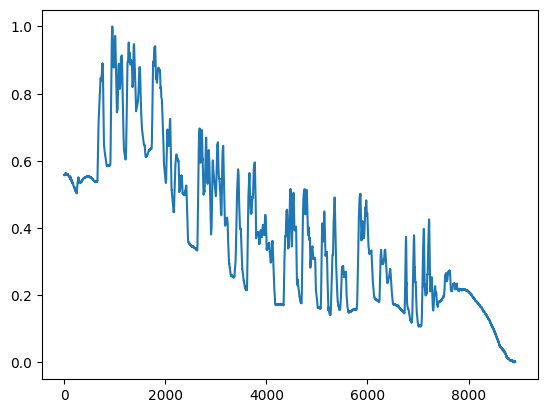

In [19]:
recorded = meanL-min(meanL)
recorded = recorded / max(recorded)

plt.plot(recorded)

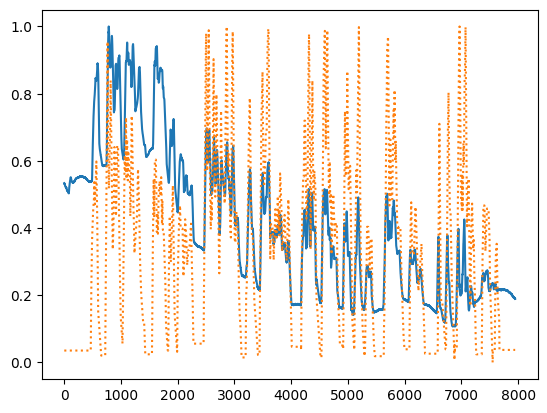

In [20]:
sig=rebuilt-min(rebuilt)
sig=sig/max(sig)

#Synchronize
overframe=len(recorded)-len(sig)
optimalSync=[math.inf,0,0]
for i in range(overframe):
    aux=np.append(np.zeros((i,1)),rebuilt)
    aux=np.append(aux,np.zeros((overframe-i,1)))
    
    thisErr=np.mean(np.power(aux-recorded,2))
    if thisErr<optimalSync[0]:
        optimalSync[0]=thisErr
        optimalSync[1]=i
        optimalSync[2]=overframe-i
    del(aux)

recSync=recorded[optimalSync[1]:len(recorded)-optimalSync[2]]
plt.plot(recSync)
plt.plot(sig,linestyle=':')

In [21]:
optimalSync

[np.float64(1104.584364197336), 167, 807]

In [22]:
#Write video at higher framerate
vidcap = cv2.VideoCapture(rVideo)
success,image = vidcap.read()
count=1

cvcodec = cv2.VideoWriter_fourcc(*'avc1')
tempfilepath="temp.mp4"
video = cv2.VideoWriter(tempfilepath,cvcodec,framerate*slowFactor,(image.shape[1],image.shape[0]))    

while success :
    if count>optimalSync[1]:
        video.write(image) #writes frame
        success,image = vidcap.read()
        count=count+1
        if count>len(recSync)+optimalSync[1]:
            break        
    else:
        success,image = vidcap.read()
        count=count+1

video.release()

In [23]:
outfilepath=projectName+'.mp4'
audiofilepath=projectName+".MP3"
vif.writeOutputFile(outfilepath,tempfilepath,audiofilepath,codec='libx264')

MoviePy - Building video SOL_20250612_jueves.mp4.
MoviePy - Writing video SOL_20250612_jueves.mp4



MoviePy - Done !
MoviePy - video ready SOL_20250612_jueves.mp4


0